In [3]:
!pip install cloud_tpu_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

21848064/21834768 [==============================] - 0s 0us/step


In [6]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224

In [7]:
from cloud_tpu_client import Client
import tensorflow as tf
import numpy as np



try:
    c = Client()
    c.configure_tpu_version(tf.__version__, restart_type="always")
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)

except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [8]:
batch_size = 64
SHUFFLE_BUFFER_SIZE = 128

x_train, x_test, y_train, y_test = np.load("/content/drive/MyDrive/steel_surface_224.npy", allow_pickle=True)
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_train = ds_train.prefetch(batch_size)
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
ds_test = ds_test.prefetch(batch_size)
print(ds_train)
print(ds_test)

<PrefetchDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>


In [9]:
NUM_CLASSES = 6

In [10]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

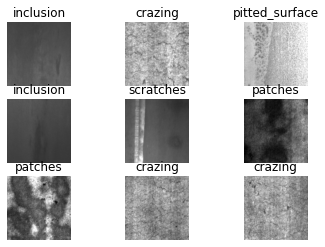

In [11]:
import matplotlib.pyplot as plt

labellist=["crazing","inclusion","patches","pitted_surface","rolled-in_scale","scratches"]
def format_label(label):
  return labellist[(int(str(label)[10]))]


for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(format_label(label))
    plt.axis("off")

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [14]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [15]:
from tensorflow.keras.applications import EfficientNetB0

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB0(include_top=True, weights=None, classes=NUM_CLASSES)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 100  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

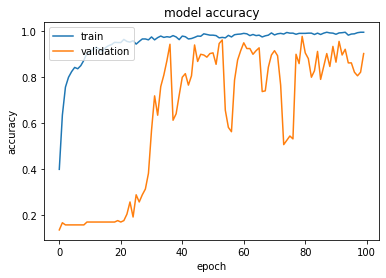

In [16]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [17]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/60
16/16 - 13s - loss: 0.3928 - accuracy: 0.8838 - val_loss: 0.4721 - val_accuracy: 0.8469 - 13s/epoch - 824ms/step
Epoch 2/60
16/16 - 3s - loss: 0.0405 - accuracy: 0.9834 - val_loss: 0.2870 - val_accuracy: 0.9031 - 3s/epoch - 159ms/step
Epoch 3/60
16/16 - 3s - loss: 0.0492 - accuracy: 0.9844 - val_loss: 0.5257 - val_accuracy: 0.7781 - 3s/epoch - 159ms/step
Epoch 4/60
16/16 - 3s - loss: 0.0266 - accuracy: 0.9912 - val_loss: 0.2631 - val_accuracy: 0.9000 - 3s/epoch - 159ms/step
Epoch 5/60
16/16 - 3s - loss: 0.0230 - accuracy: 0.9922 - val_loss: 0.2809 - val_accuracy: 0.9156 - 3s/epoch - 160ms/step
Epoch 6/60
16/16 - 3s - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.2667 - val_accuracy: 0.8969 - 3s/epoch - 160ms/step
Epoch 7/60
16/16 - 3s - loss: 0.0448 - accuracy: 0.9873 - val_loss: 0.1157 - val_accuracy: 0.9625 - 3s/epoch - 160ms/step
Epoch 8/60
16/16 - 3s - loss: 0.0600 - accuracy: 0.9902 - val_loss: 0.1410 - va

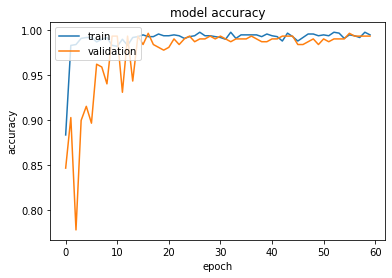

In [18]:
with strategy.scope():
    model = build_model(num_classes=NUM_CLASSES)

epochs = 60  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

Epoch 1/10
16/16 - 13s - loss: 0.0363 - accuracy: 0.9990 - val_loss: 0.0719 - val_accuracy: 0.9906 - 13s/epoch - 808ms/step
Epoch 2/10
16/16 - 3s - loss: 0.0869 - accuracy: 0.9912 - val_loss: 0.0396 - val_accuracy: 0.9937 - 3s/epoch - 170ms/step
Epoch 3/10
16/16 - 3s - loss: 0.0140 - accuracy: 0.9990 - val_loss: 0.0846 - val_accuracy: 0.9906 - 3s/epoch - 171ms/step
Epoch 4/10
16/16 - 3s - loss: 0.0270 - accuracy: 0.9990 - val_loss: 0.1240 - val_accuracy: 0.9906 - 3s/epoch - 170ms/step
Epoch 5/10
16/16 - 3s - loss: 0.0410 - accuracy: 0.9941 - val_loss: 0.1174 - val_accuracy: 0.9688 - 3s/epoch - 171ms/step
Epoch 6/10
16/16 - 3s - loss: 0.0130 - accuracy: 0.9980 - val_loss: 0.5183 - val_accuracy: 0.9531 - 3s/epoch - 172ms/step
Epoch 7/10
16/16 - 3s - loss: 0.0236 - accuracy: 0.9961 - val_loss: 0.1408 - val_accuracy: 0.9719 - 3s/epoch - 171ms/step
Epoch 8/10
16/16 - 3s - loss: 0.0130 - accuracy: 0.9980 - val_loss: 0.0889 - val_accuracy: 0.9906 - 3s/epoch - 173ms/step
Epoch 9/10
16/16 - 3s 

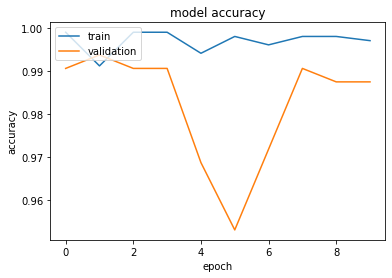

In [19]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)
plot_hist(hist)

In [20]:
model.evaluate(ds_test)

5/5 [==============================] - 1s 114ms/step - loss: 0.1086 - accuracy: 0.9875


[0.10864289849996567, 0.987500011920929]

In [21]:
#Test set 정확도
y_pred_test=model.predict(x_test)
print(y_pred_test, type(y_pred_test), y_pred_test.shape)
y_pred=[]
for ar in y_pred_test:
  y_pred.append(np.argmax(ar))
y_pred = np.array(y_pred)
print(y_pred, y_pred.shape)
print(y_test, y_test.shape)

[[4.85605379e-24 1.00000000e+00 4.53589493e-18 1.09366038e-09
  2.03093861e-11 7.52459206e-12]
 [5.13063153e-27 1.05372479e-35 1.00631875e-36 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 5.51050960e-23 2.57943369e-32
  2.81074782e-31 2.71642548e-38]
 ...
 [4.32126858e-33 5.70268858e-27 8.63527987e-17 0.00000000e+00
  1.00000000e+00 6.54292761e-28]
 [7.05483898e-35 1.03684571e-36 1.46436786e-23 0.00000000e+00
  1.00000000e+00 9.37925657e-34]
 [1.54426395e-30 1.99753078e-26 7.48791898e-14 4.63149013e-38
  1.00000000e+00 2.25698406e-23]] <class 'numpy.ndarray'> (360, 6)
[1 3 0 0 2 0 2 0 5 4 2 2 1 5 0 4 5 2 3 2 2 0 4 0 0 5 2 4 2 2 2 0 2 5 0 2 1
 3 3 4 3 3 3 4 1 3 5 3 5 1 4 3 5 5 0 0 0 1 0 2 1 1 2 4 0 4 1 5 1 2 2 5 2 1
 1 3 0 5 2 2 5 2 0 4 1 1 2 3 2 1 5 1 2 4 1 5 2 0 4 2 3 0 3 1 1 1 1 4 4 1 5
 1 4 4 2 4 5 2 0 4 1 2 3 1 3 4 2 1 5 0 3 0 0 0 2 1 0 0 3 0 1 3 0 5 2 0 4 0
 0 5 5 5 3 1 5 0 4 3 0 2 1 5 3 2 4 1 1 5 5 4 5 1 4 2 5 2 0 3 1 2 0 5 3 0 0
 0 2 4 3 1 0 3 4

In [22]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
print("accuracy:",accuracy_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred, average='weighted'))
print("Recall:",recall_score(y_test, y_pred, average='weighted'))
print("F1-Score:",f1_score(y_test, y_pred, average='weighted'))

accuracy: 0.9861111111111112
Precision: 0.9864503205128204
Recall: 0.9861111111111112
F1-Score: 0.9860647153954241


In [23]:
#Train set 정확도

y_pred_train=model.predict(x_train)
print(y_pred_train, type(y_pred_train), y_pred_train.shape)
y_train_list=[]
for ar in y_pred_train:
  y_train_list.append(np.argmax(ar))
y_train_list = np.array(y_train_list)
print(y_pred_train, y_pred_train.shape)
print(y_train_list, y_train_list.shape)

[[3.6911805e-30 1.0000000e+00 5.2232197e-23 2.3538875e-14 6.7307123e-15
  1.3768682e-10]
 [1.0000000e+00 0.0000000e+00 1.9880149e-17 5.4316758e-33 7.5021769e-24
  0.0000000e+00]
 [6.6828095e-33 0.0000000e+00 3.4384523e-34 1.0000000e+00 0.0000000e+00
  0.0000000e+00]
 ...
 [0.0000000e+00 5.0856206e-34 4.3288827e-37 5.4618745e-30 1.1777490e-37
  1.0000000e+00]
 [5.3148908e-24 0.0000000e+00 1.0000000e+00 1.8643507e-31 1.5280357e-33
  3.9699646e-38]
 [4.1433010e-24 1.9745371e-34 2.8447488e-38 1.0000000e+00 1.2122007e-35
  0.0000000e+00]] <class 'numpy.ndarray'> (1080, 6)
[[3.6911805e-30 1.0000000e+00 5.2232197e-23 2.3538875e-14 6.7307123e-15
  1.3768682e-10]
 [1.0000000e+00 0.0000000e+00 1.9880149e-17 5.4316758e-33 7.5021769e-24
  0.0000000e+00]
 [6.6828095e-33 0.0000000e+00 3.4384523e-34 1.0000000e+00 0.0000000e+00
  0.0000000e+00]
 ...
 [0.0000000e+00 5.0856206e-34 4.3288827e-37 5.4618745e-30 1.1777490e-37
  1.0000000e+00]
 [5.3148908e-24 0.0000000e+00 1.0000000e+00 1.8643507e-31 1.52803

In [24]:
print("accuracy:",accuracy_score(y_train, y_train_list))
print("Precision:",precision_score(y_train, y_train_list, average='weighted'))
print("Recall:",recall_score(y_train, y_train_list, average='weighted'))
print("F1-Score:",f1_score(y_train, y_train_list, average='weighted'))

accuracy: 0.9981481481481481
Precision: 0.9981481481481481
Recall: 0.9981481481481481
F1-Score: 0.9981481481481481


In [25]:
#운영체제 확인
!cat /etc/issue

#0. CPU 정보 확인
!cat /proc/cpuinfo

#1. CPU 코어 전체 개수 확인
!grep -c processor /proc/cpuinfo
 
#2. 물리 CPU 수 확인
!grep "physical id" /proc/cpuinfo | sort -u | wc -l
 
# 3.CPU당 물리 코어 수 확인
!grep "cpu cores" /proc/cpuinfo | tail -1

#메모리 확인
!free -h

#런타임 유형 변경 후 gpu 확인
!nvidia-smi

Ubuntu 18.04.5 LTS \n \l

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address size